In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [60]:
df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dataset Shape: 235,795 rows × 56 columns


In [61]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [62]:
def categorize_features(df):
    feature_categories = {
        'identifiers': ['FILENAME', 'URL', 'Domain', 'TLD', 'Title'],
        
        'url_structure': ['URLLength', 'DomainLength', 'TLDLength', 
                         'NoOfSubDomain', 'IsDomainIP'],
        
        'url_content': ['NoOfLettersInURL', 'LetterRatioInURL', 
                       'NoOfDegitsInURL', 'DegitRatioInURL',
                       'NoOfEqualsInURL', 'NoOfQMarkInURL', 
                       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
                       'SpacialCharRatioInURL'],
        
        'obfuscation': ['HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio'],
        
        'probability_scores': ['URLSimilarityIndex', 'CharContinuationRate',
                              'TLDLegitimateProb', 'URLCharProb'],
        
        'page_structure': ['LineOfCode', 'LargestLineLength', 'HasTitle',
                          'DomainTitleMatchScore', 'URLTitleMatchScore',
                          'HasFavicon', 'Robots', 'IsResponsive', 'HasDescription'],
        
        'redirects': ['NoOfURLRedirect', 'NoOfSelfRedirect'],
        
        'security': ['IsHTTPS', 'HasExternalFormSubmit', 'HasHiddenFields',
                    'HasPasswordField', 'HasSubmitButton'],
        
        'content_indicators': ['NoOfPopup', 'NoOfiFrame', 'HasSocialNet',
                              'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo'],
        
        'resources': ['NoOfImage', 'NoOfCSS', 'NoOfJS', 
                     'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef'],
        
        'target': ['label']
    }
    
    for category, features in feature_categories.items():
        present = [f for f in features if f in df.columns]
        print(f"\n{category.upper()} ({len(present)} features):")
        print(f"  {', '.join(present)}")
    
    return feature_categories

feature_categories = categorize_features(df)


IDENTIFIERS (5 features):
  FILENAME, URL, Domain, TLD, Title

URL_STRUCTURE (5 features):
  URLLength, DomainLength, TLDLength, NoOfSubDomain, IsDomainIP

URL_CONTENT (9 features):
  NoOfLettersInURL, LetterRatioInURL, NoOfDegitsInURL, DegitRatioInURL, NoOfEqualsInURL, NoOfQMarkInURL, NoOfAmpersandInURL, NoOfOtherSpecialCharsInURL, SpacialCharRatioInURL

OBFUSCATION (3 features):
  HasObfuscation, NoOfObfuscatedChar, ObfuscationRatio

PROBABILITY_SCORES (4 features):
  URLSimilarityIndex, CharContinuationRate, TLDLegitimateProb, URLCharProb

PAGE_STRUCTURE (9 features):
  LineOfCode, LargestLineLength, HasTitle, DomainTitleMatchScore, URLTitleMatchScore, HasFavicon, Robots, IsResponsive, HasDescription

REDIRECTS (2 features):
  NoOfURLRedirect, NoOfSelfRedirect

SECURITY (5 features):
  IsHTTPS, HasExternalFormSubmit, HasHiddenFields, HasPasswordField, HasSubmitButton

CONTENT_INDICATORS (7 features):
  NoOfPopup, NoOfiFrame, HasSocialNet, Bank, Pay, Crypto, HasCopyrightInfo

RESOUR

In [63]:
label_counts = df['label'].value_counts()
label_percentages = df['label'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print("="*40)
for label in label_counts.index:
    print(f"  {label}: {label_counts[label]:,} ({label_percentages[label]:.2f}%)")

# Imbalance ratio
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

Target Variable Distribution:
  1: 134,850 (57.19%)
  0: 100,945 (42.81%)

Imbalance Ratio: 1.34:1


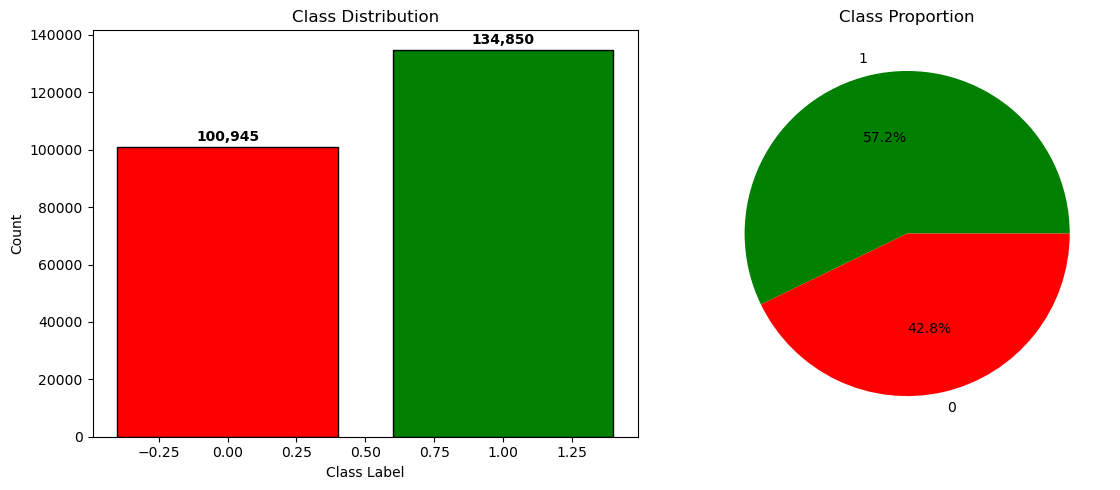

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
colors = ['Green', 'Red']  # Green for legit, red for phishing
ax1 = axes[0]
bars = ax1.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution')
for bar, count in zip(bars, label_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(label_counts.values, labels=label_counts.index,autopct='%1.1f%%', colors=colors,)
ax2.set_title('Class Proportion')

plt.tight_layout()
plt.show()

In [65]:
# Identify numeric features
exclude_cols = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title', 'label']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

print(f"Numeric Features: {len(numeric_cols)}")

# Statistics
stats_df = df[numeric_cols].describe().T
stats_df['median'] = df[numeric_cols].median()
stats_df['skewness'] = df[numeric_cols].skew()
stats_df['IQR'] = stats_df['75%'] - stats_df['25%']

# Reorder
stats_df = stats_df[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR', 'skewness']]
stats_df

Numeric Features: 50


,count,mean,median,std,min,25%,50%,75%,max,IQR,skewness,kurtosis
URLLength,235795.0,34.573095,27.000000,41.314153,13.000000,23.000000,27.000000,34.000000,6.097000e+03,11.000000,53.321737,5914.008979
DomainLength,235795.0,21.470396,20.000000,9.150793,4.000000,16.000000,20.000000,24.000000,1.100000e+02,8.000000,2.513397,10.660247
IsDomainIP,235795.0,0.002706,0.000000,0.051946,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,19.146593,364.595109
URLSimilarityIndex,235795.0,78.430778,100.000000,28.976055,0.155574,57.024793,100.000000,100.000000,1.000000e+02,42.975207,-0.989903,-0.408037
CharContinuationRate,235795.0,0.845508,1.000000,0.216632,0.000000,0.680000,1.000000,1.000000,1.000000e+00,0.320000,-1.128591,0.056455
TLDLegitimateProb,235795.0,0.260423,0.079963,0.251628,0.000000,0.005977,0.079963,0.522907,5.229071e-01,0.516930,0.073090,-1.973777
URLCharProb,235795.0,0.055747,0.057970,0.010587,0.001083,0.050747,0.057970,0.062875,9.082366e-02,0.012128,-1.064291,1.461184
TLDLength,235795.0,2.764456,3.000000,0.599739,2.000000,2.000000,3.000000,3.000000,1.300000e+01,1.000000,1.663518,13.738667
NoOfSubDomain,235795.0,1.164758,1.000000,0.600969,0.000000,1.000000,1.000000,1.000000,1.000000e+01,0.000000,1.809400,7.788128
HasObfuscation,235795.0,0.002057,0.000000,0.045306,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,21.981435,481.187548


In [66]:
# Skewed features
highly_skewed = stats_df[abs(stats_df['skewness']) > 2].sort_values('skewness', ascending=False)


print("="*50)
print(highly_skewed[['mean', 'median', 'skewness']].to_string())

                                    mean  median    skewness
NoOfCSS                         6.333111     2.0  464.404031
NoOfObfuscatedChar              0.024861     0.0  204.684335
NoOfJS                         10.522305     6.0  140.435761
NoOfEqualsInURL                 0.062241     0.0  114.985479
NoOfEmptyRef                    2.377629     0.0  106.826225
NoOfAmpersandInURL              0.025056     0.0  106.717256
NoOfiFrame                      1.588638     0.0   97.677347
NoOfDegitsInURL                 1.881011     0.0   94.877574
NoOfPopup                       0.221765     0.0   84.952694
NoOfExternalRef                49.262516    10.0   65.900247
NoOfSelfRef                    65.071113    12.0   60.381378
NoOfLettersInURL               19.428919    14.0   58.402581
URLLength                      34.573095    27.0   53.321737
LineOfCode                   1141.900443   429.0   53.072297
LargestLineLength           12789.532624  1090.0   48.179926
NoOfOtherSpecialCharsInU

In [67]:
# Binary features
binary_features = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 
                   'HasFavicon', 'IsResponsive', 'HasDescription',
                   'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
                   'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 
                   'Crypto', 'HasCopyrightInfo']

binary_features = [f for f in binary_features if f in df.columns]

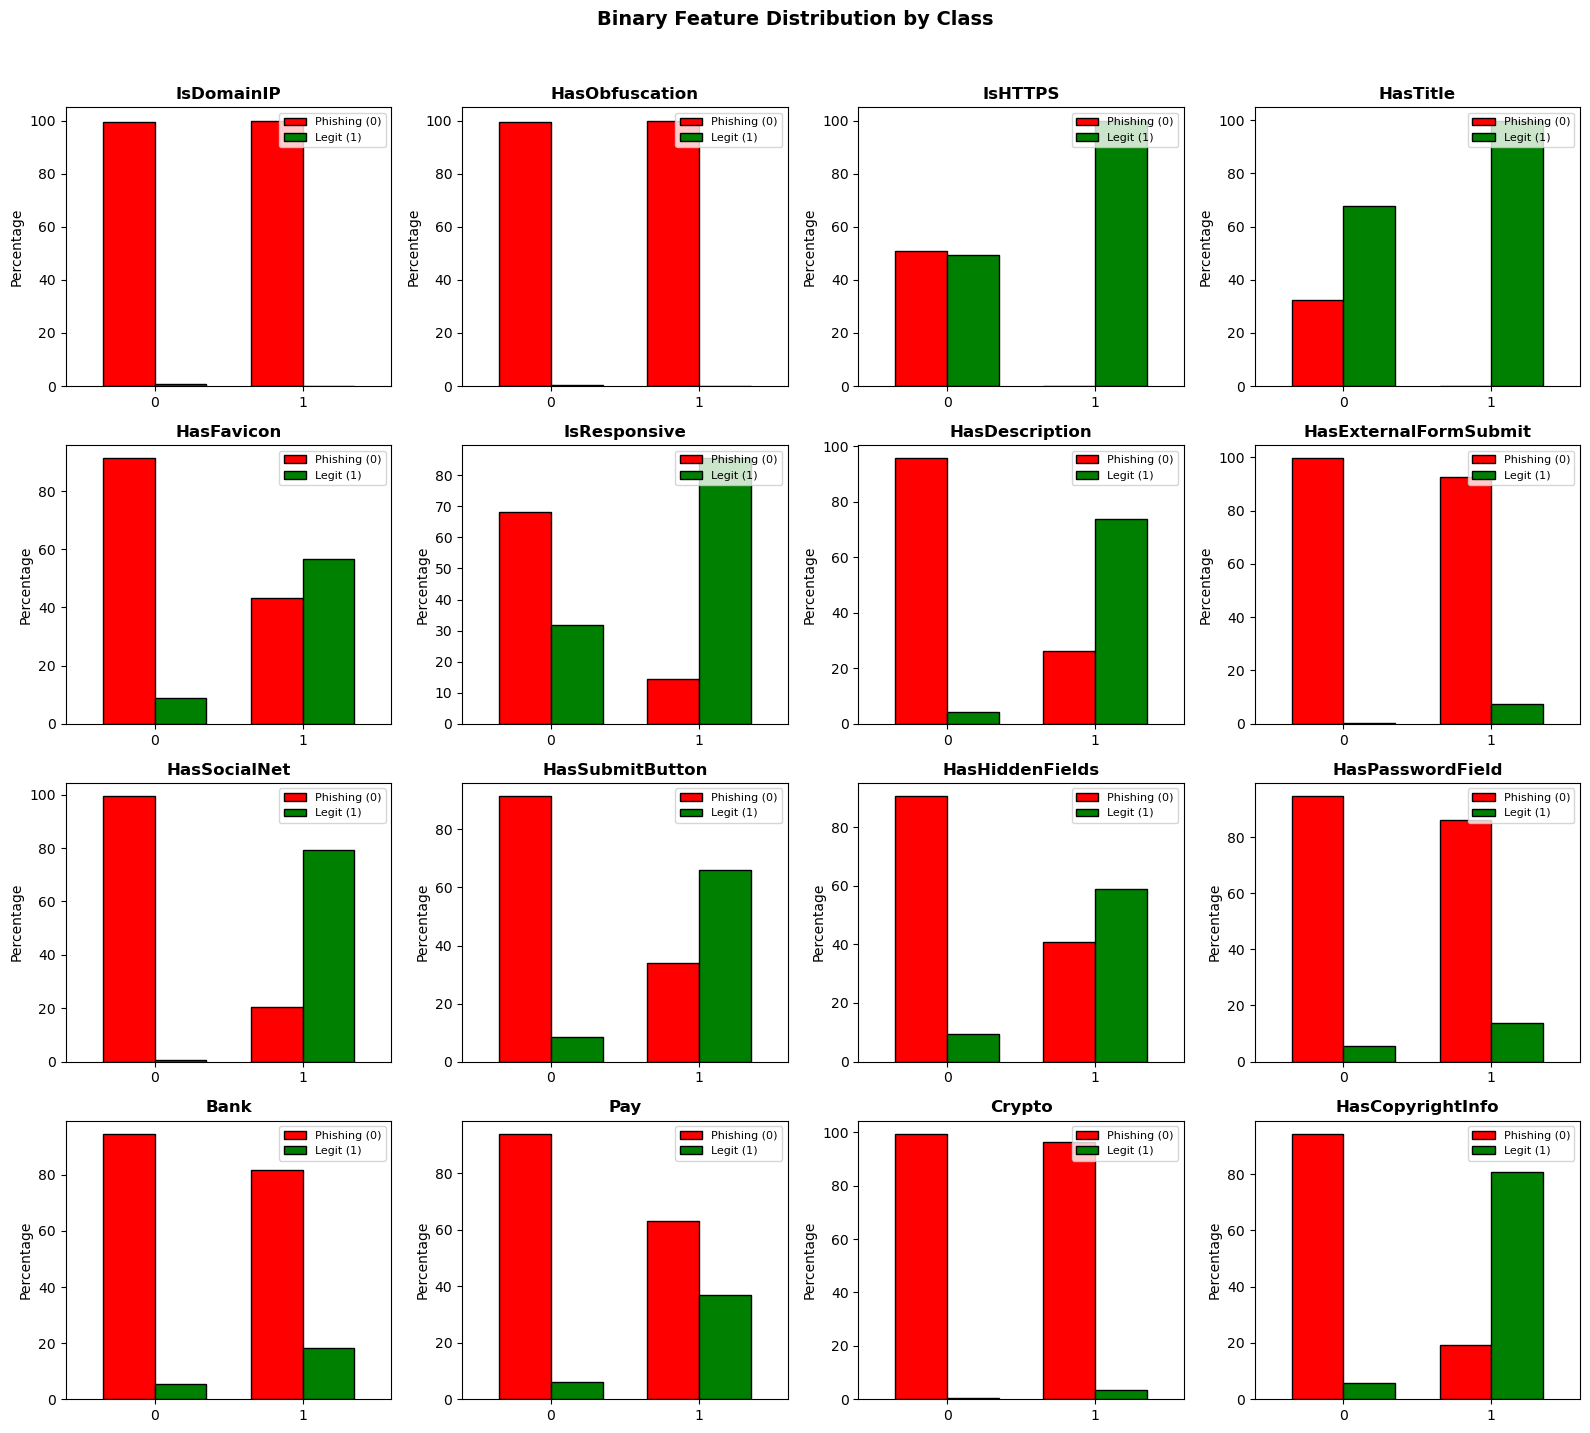

In [68]:
# Binary features by class
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, feature in enumerate(binary_features):
    if idx < len(axes):
        ax = axes[idx]
        
        # Calculate proportions by class
        cross_tab = pd.crosstab(df['label'], df[feature], normalize='index') * 100
        
        cross_tab.plot(kind='bar', ax=ax, color=['Red', 'Green'], 
                      edgecolor='black', width=0.7)
        ax.set_title(feature, fontweight='bold')
        ax.set_ylabel('Percentage')
        ax.set_xlabel('')
        ax.legend(['Phishing (0)', 'Legit (1)'], loc='upper right', fontsize=8)
        ax.tick_params(axis='x', rotation=0)

# Hide empty subplots
for idx in range(len(binary_features), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Binary Feature Distribution by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

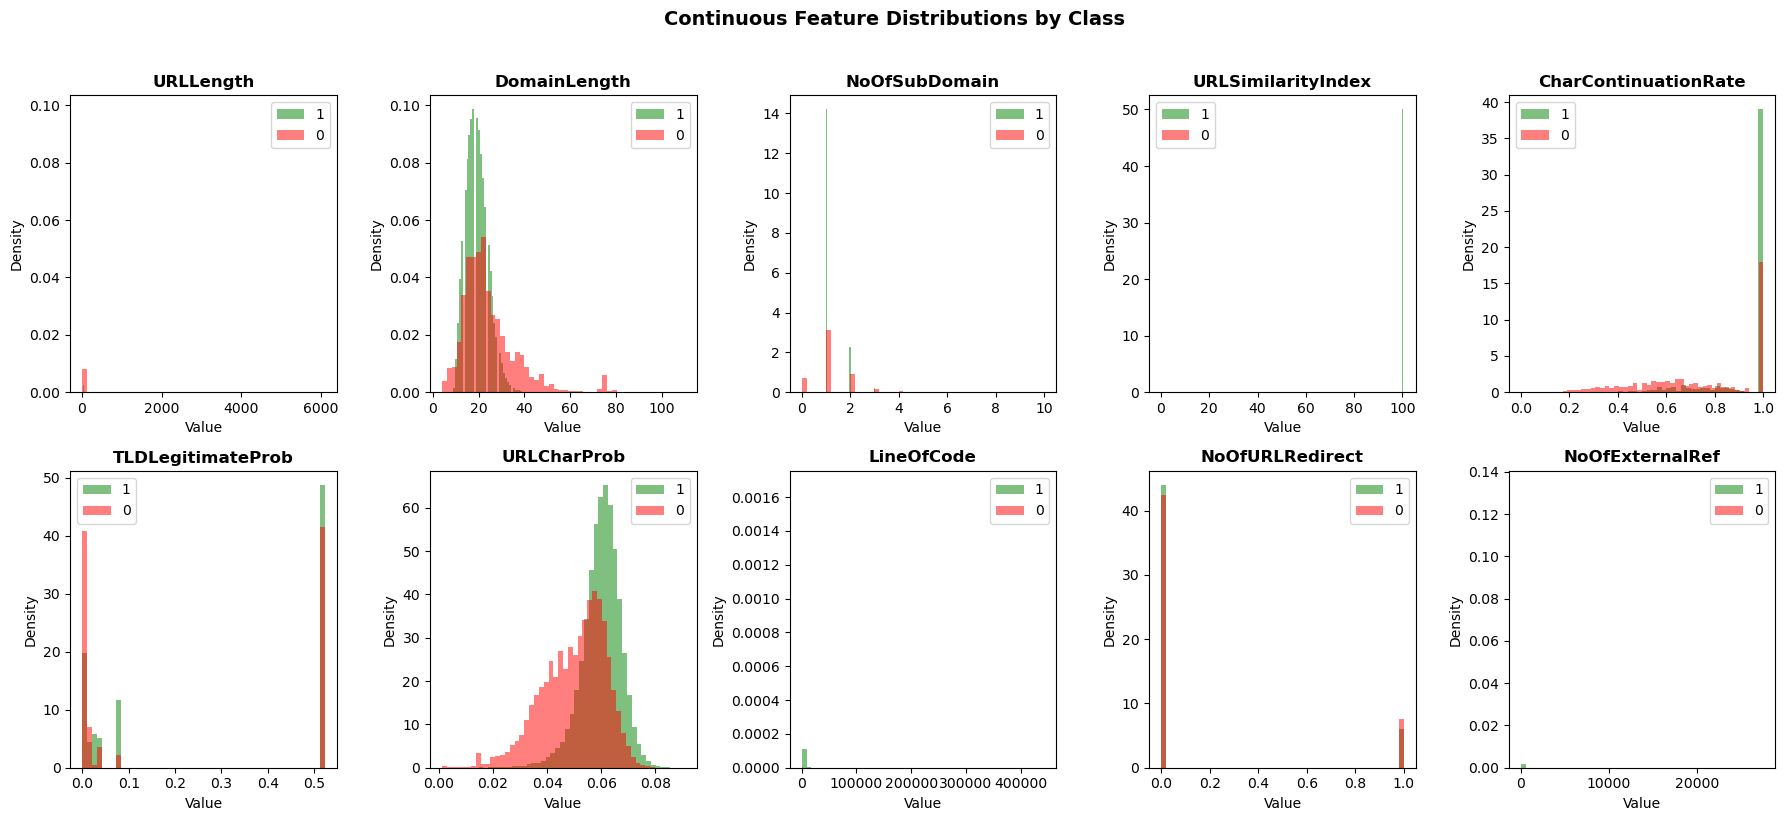

In [69]:
# Continuous features distribution
continuous_features = ['URLLength', 'DomainLength', 'NoOfSubDomain', 
                       'URLSimilarityIndex', 'CharContinuationRate',
                       'TLDLegitimateProb', 'URLCharProb', 'LineOfCode',
                       'NoOfURLRedirect', 'NoOfExternalRef']

continuous_features = [f for f in continuous_features if f in df.columns]

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    ax = axes[idx]
    
    # Plot by class
    for label, color in zip(df['label'].unique(), ['Green', 'Red']):
        subset = df[df['label'] == label][feature].dropna()
        ax.hist(subset, bins=50, alpha=0.5, label=label, color=color, density=True)
    
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

plt.suptitle('Continuous Feature Distributions by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [70]:
def calculate_feature_importance_proxies(df, numeric_cols, target='label'):

    results = []
    
    for col in numeric_cols:
        if col == target:
            continue
            
        # Separate by class
        class_0 = df[df[target] == df[target].unique()[0]][col].dropna()
        class_1 = df[df[target] == df[target].unique()[1]][col].dropna()
        
        # Cohen's d (effect size)
        pooled_std = np.sqrt((class_0.std()**2 + class_1.std()**2) / 2)
        cohens_d = abs(class_0.mean() - class_1.mean()) / pooled_std if pooled_std > 0 else 0
        
        # Point-biserial correlation
        correlation = df[[col, target]].dropna()[col].corr(df[[col, target]].dropna()[target].astype(int))
        
        results.append({
            'Feature': col,
            'Cohens_d': cohens_d,
            'Correlation': correlation,
            'Abs_Correlation': abs(correlation)
        })
    
    return pd.DataFrame(results).sort_values('Abs_Correlation', ascending=False)

# Map labels to numeric if needed
if df['label'].dtype == 'object':
    df['label_numeric'] = df['label'].map({'legitimate': 0, 'phishing': 1})
else:
    df['label_numeric'] = df['label']

importance_df = calculate_feature_importance_proxies(df, numeric_cols, 'label_numeric')
print("Top 20 Features by Correlation with Target:")
importance_df.head(20)

Top 20 Features by Correlation with Target:


,Feature,Cohens_d,Correlation,Abs_Correlation
3,URLSimilarityIndex,3.156659,0.860358,0.860358
36,HasSocialNet,2.721797,0.784255,0.784255
43,HasCopyrightInfo,2.322639,0.743358,0.743358
32,HasDescription,2.014926,0.690232,0.690232
21,IsHTTPS,1.436333,0.609132,0.609132
25,DomainTitleMatchScore,1.472565,0.584905,0.584905
37,HasSubmitButton,1.482722,0.578561,0.578561
29,IsResponsive,1.300067,0.548608,0.548608
26,URLTitleMatchScore,1.299525,0.539419,0.539419
20,SpacialCharRatioInURL,1.222859,-0.533537,0.533537


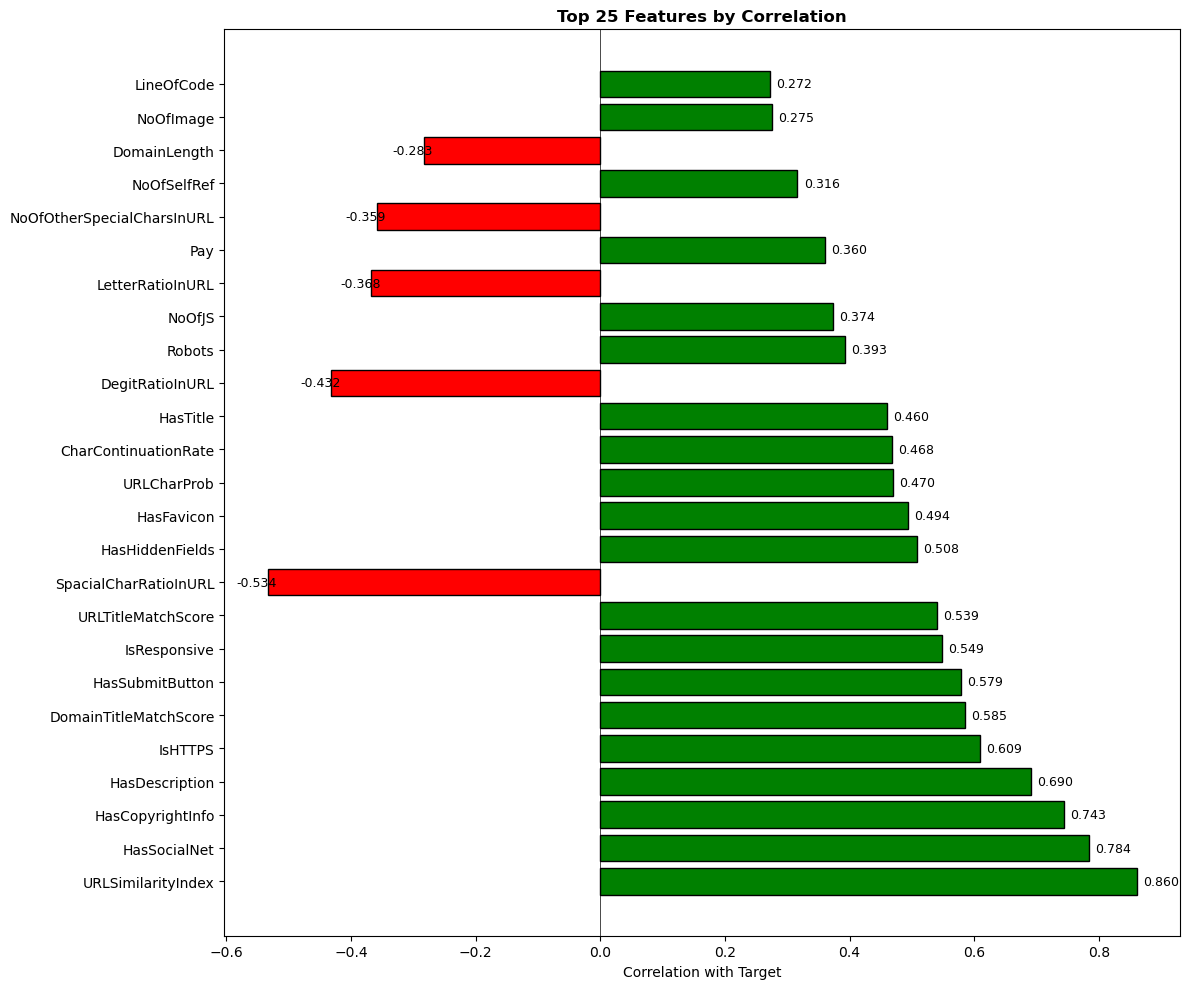

In [71]:
# Visualize correlations
fig, ax = plt.subplots(figsize=(12, 10))

top_features = importance_df.head(25)
colors = ['Red' if c < 0 else 'Green' for c in top_features['Correlation']]

bars = ax.barh(range(len(top_features)), top_features['Correlation'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Correlation with Target')
ax.set_title('Top 25 Features by Correlation', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)

# Add value labels
for bar, val in zip(bars, top_features['Correlation']):
    ax.text(val + 0.01 if val >= 0 else val - 0.05, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [72]:
# Effect size analysis
large_effect = importance_df[importance_df['Cohens_d'] >= 0.8].sort_values('Cohens_d', ascending=False)
medium_effect = importance_df[(importance_df['Cohens_d'] >= 0.5) & (importance_df['Cohens_d'] < 0.8)]

print(f"Features with Large Effect Size (≥0.8): {len(large_effect)}")
if len(large_effect) > 0:
    print(large_effect[['Feature', 'Cohens_d', 'Correlation']].to_string(index=False))

print(f"\nFeatures with Medium Effect Size (0.5-0.8): {len(medium_effect)}")
if len(medium_effect) > 0:
    print(medium_effect[['Feature', 'Cohens_d', 'Correlation']].head(10).to_string(index=False))

Features with Large Effect Size (≥0.8): 19
              Feature  Cohens_d  Correlation
   URLSimilarityIndex  3.156659     0.860358
         HasSocialNet  2.721797     0.784255
     HasCopyrightInfo  2.322639     0.743358
       HasDescription  2.014926     0.690232
      HasSubmitButton  1.482722     0.578561
DomainTitleMatchScore  1.472565     0.584905
              IsHTTPS  1.436333     0.609132
         IsResponsive  1.300067     0.548608
   URLTitleMatchScore  1.299525     0.539419
      HasHiddenFields  1.231621     0.507731
SpacialCharRatioInURL  1.222859    -0.533537
           HasFavicon  1.188613     0.493711
          URLCharProb  1.040066     0.469749
 CharContinuationRate  1.029886     0.467735
             HasTitle  0.968996     0.459725
      DegitRatioInURL  0.899259    -0.432032
               Robots  0.898962     0.392620
               NoOfJS  0.868623     0.373500
                  Pay  0.812626     0.359747

Features with Medium Effect Size (0.5-0.8): 9
          

C:\Users\Eight\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


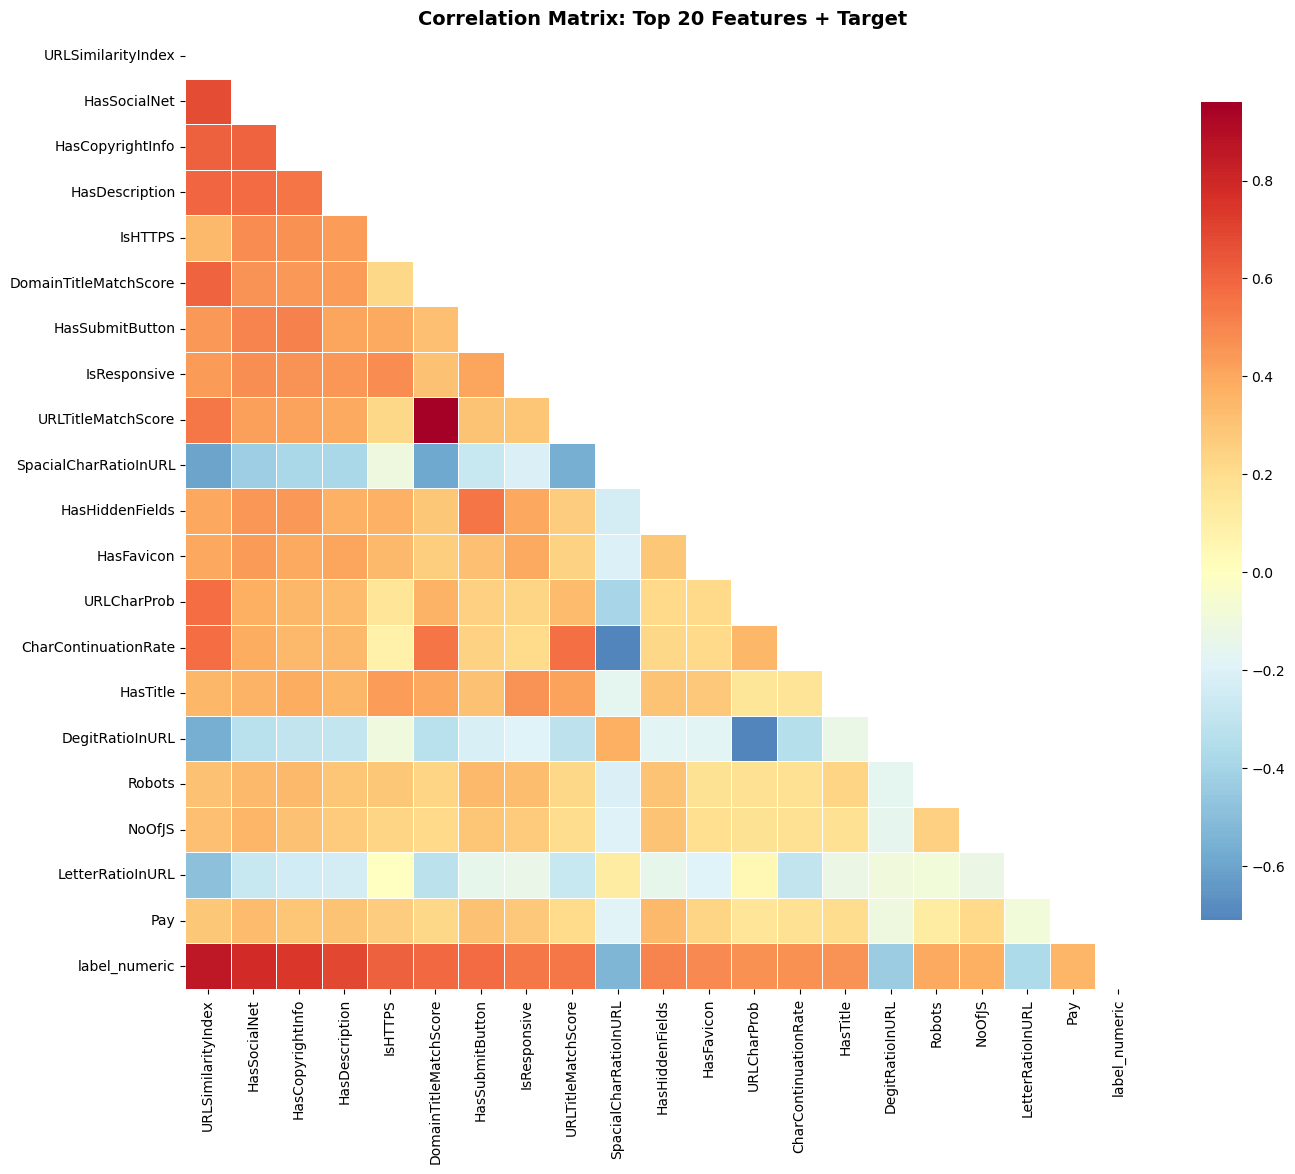

In [73]:
# Correlation matrix for top features
top_correlated_features = importance_df.head(20)['Feature'].tolist()
top_correlated_features.append('label_numeric')

corr_matrix = df[top_correlated_features].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8},
            ax=ax, annot_kws={'size': 8})

ax.set_title('Correlation Matrix: Top 20 Features + Target', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [74]:
def detect_outliers_iqr(df, columns):
    outlier_info = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_pct = len(outliers) / len(df) * 100
        
        outlier_info.append({
            'Feature': col,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Outlier_Count': len(outliers),
            'Outlier_Pct': outlier_pct
        })
    
    return pd.DataFrame(outlier_info).sort_values('Outlier_Pct', ascending=False)

outlier_df = detect_outliers_iqr(df, numeric_cols)
print("Features with Most Outliers (IQR Method):")
outlier_df.head(25)

Features with Most Outliers (IQR Method):


,Feature,Lower_Bound,Upper_Bound,Outlier_Count,Outlier_Pct
8,NoOfSubDomain,1.0,1.0,57389,24.338514
41,Pay,0.0,0.0,55885,23.700672
14,NoOfDegitsInURL,0.0,0.0,51461,21.824466
15,DegitRatioInURL,0.0,0.0,51461,21.824466
21,IsHTTPS,1.0,1.0,51256,21.737526
48,NoOfEmptyRef,-1.5,2.5,38885,16.491020
34,NoOfiFrame,-1.5,2.5,34441,14.606332
24,HasTitle,1.0,1.0,32714,13.873916
30,NoOfURLRedirect,0.0,0.0,31464,13.343794
40,Bank,0.0,0.0,29967,12.708921


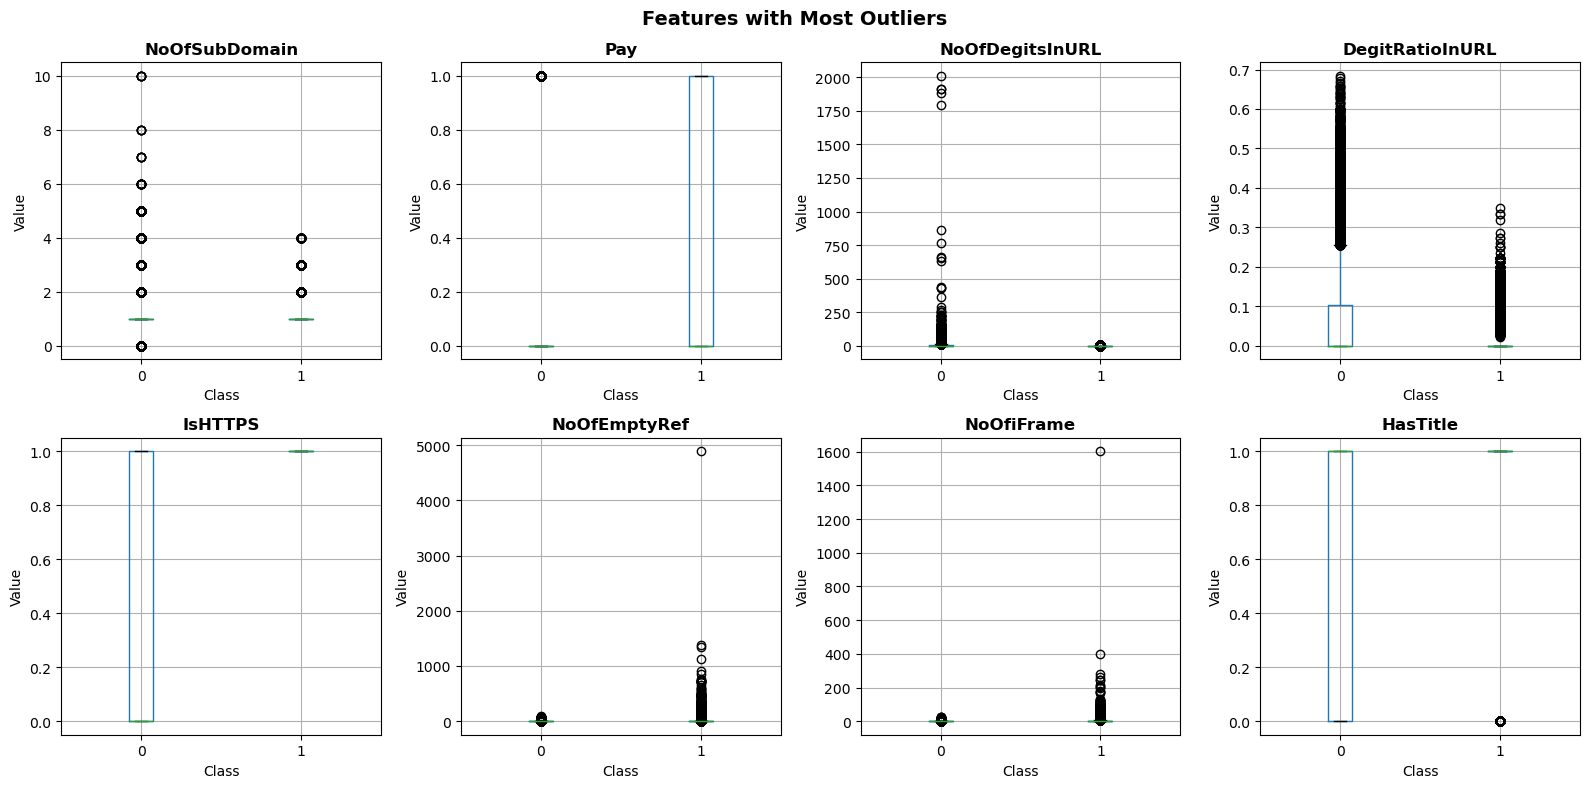

In [75]:
# Top outlier features
top_outlier_features = outlier_df.head(8)['Feature'].tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_outlier_features):
    ax = axes[idx]
    df.boxplot(column=feature, by='label', ax=ax)
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Class')
    ax.set_ylabel('Value')

plt.suptitle('Features with Most Outliers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

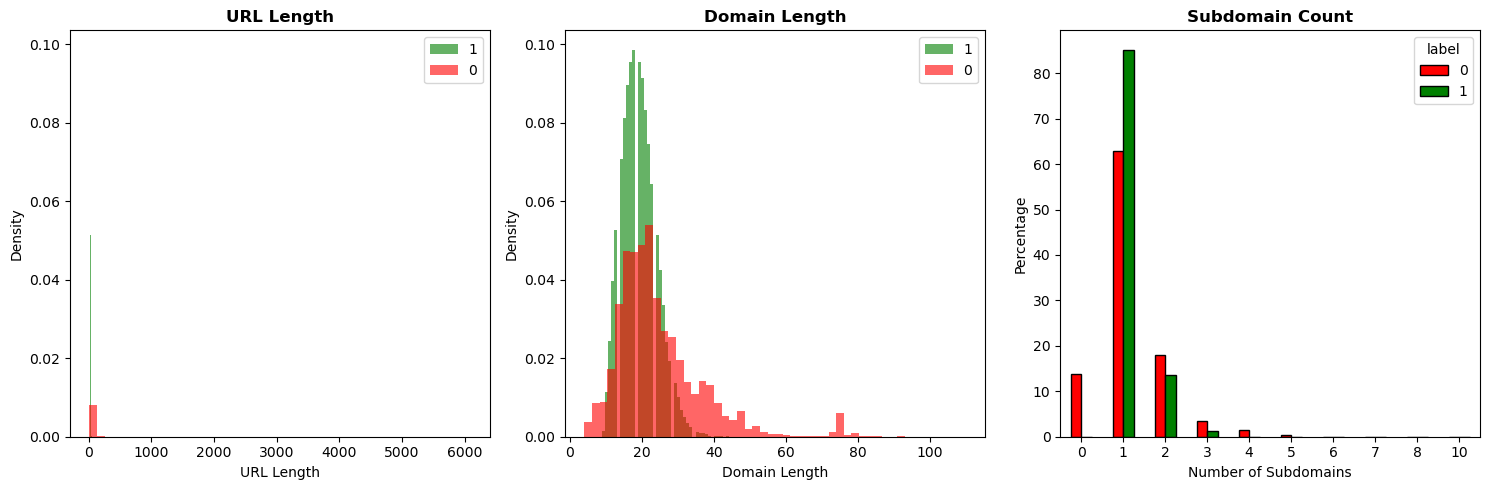

In [76]:
# URL Length comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# URL Length
ax1 = axes[0]
for label, color in zip(df['label'].unique(), ['Green', 'Red']):
    subset = df[df['label'] == label]['URLLength']
    ax1.hist(subset, bins=50, alpha=0.6, label=label, color=color, density=True)
ax1.set_xlabel('URL Length')
ax1.set_ylabel('Density')
ax1.set_title('URL Length', fontweight='bold')
ax1.legend()

# Domain Length
ax2 = axes[1]
for label, color in zip(df['label'].unique(), ['Green', 'Red']):
    subset = df[df['label'] == label]['DomainLength']
    ax2.hist(subset, bins=50, alpha=0.6, label=label, color=color, density=True)
ax2.set_xlabel('Domain Length')
ax2.set_ylabel('Density')
ax2.set_title('Domain Length', fontweight='bold')
ax2.legend()

# Number of Subdomains
ax3 = axes[2]
cross_tab = pd.crosstab(df['NoOfSubDomain'], df['label'], normalize='columns') * 100
cross_tab.head(10).plot(kind='bar', ax=ax3, color=['Red', 'Green'], edgecolor='black')
ax3.set_xlabel('Number of Subdomains')
ax3.set_ylabel('Percentage')
ax3.set_title('Subdomain Count', fontweight='bold')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()